# Hoja de trabajo 2

Link del repositorio: https://github.com/faguilarleal/HDT2_deep  


Integrantes:  
- Franci Aguilar 22243
- César López 22404


## Ejercicio 1. Experimentación práctica
#### Task 1 - Preparación del conjunto de datos
Cargue el conjunto de datos de Iris utilizando bibliotecas como sklearn.datasets. Luego, divida el conjunto de datos en conjuntos de entrenamiento y validación.


In [16]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy
from PIL import Image
import os
from collections import defaultdict
import torch
from torch import nn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import pandas as pd
import inspect
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import time
from sklearn.metrics import f1_score


In [17]:
# Cargar el conjunto de datos Iris
iris = load_iris()

# Convertir a DataFrame para verlo más ordenado
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target

print("Primeras filas del dataset:")
print(df.head())

X = iris.data
y = iris.target

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTamaños de los conjuntos:")
print("Entrenamiento:", X_train.shape, y_train.shape)
print("Validación:", X_val.shape, y_val.shape)


Primeras filas del dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  

Tamaños de los conjuntos:
Entrenamiento: (120, 4) (120,)
Validación: (30, 4) (30,)


#### Task 2 - Arquitectura modelo
Cree una red neuronal feedforward simple utilizando nn.Module de PyTorch. Luego, defina capa de entrada, capas ocultas y capa de salida. Después, elija las funciones de activación y el número de neuronas por capa.

In [18]:
import torch.nn.functional as F

class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        # Capa de entrada -> 4 neuronas 
        # Primera capa oculta -> 16 neuronas
        # Segunda capa oculta -> 8 neuronas
        # Capa de salida -> 3 neuronas (porque iris tiene 3 clases)
        self.fc1 = nn.Linear(4, 16)   # entrada -> capa oculta 1
        self.fc2 = nn.Linear(16, 8)   # capa oculta 1 -> capa oculta 2
        self.fc3 = nn.Linear(8, 3)    # capa oculta 2 -> salida

    def forward(self, x):
        # Funciones de activación
        x = F.relu(self.fc1(x))  
        x = F.relu(self.fc2(x))  
        x = self.fc3(x)         
        return x

# Instanciar el modelo
model = IrisNet()
print(model)


IrisNet(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=3, bias=True)
)


#### Task 3 - Funciones de Pérdida
Utilice diferentes funciones de pérdida comunes como Cross-Entropy Loss y MSE para clasificación. Entrene el modelo con diferentes funciones de pérdida y registre las pérdidas de entrenamiento y test. Debe utilizar al menos 3 diferentes funciones. Es decir, procure que su código sea capaz de parametrizar el uso de diferentes funciones de pérdida.

In [19]:
import torch.optim as optim

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val   = torch.tensor(X_val, dtype=torch.float32)
y_val   = torch.tensor(y_val, dtype=torch.long)

#  Funciones de pérdida disponibles
loss_functions = {
    "CrossEntropy": nn.CrossEntropyLoss(),
    "MSE": nn.MSELoss(),  # MSE requiere one-hot en y
    "NLLLoss": nn.NLLLoss()  # requiere log_softmax en salida
}


#  Entrenamiento parametrizable
def train_model(loss_name, epochs=50, lr=0.01):
    model = IrisNet()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    criterion = loss_functions[loss_name]

    # Para NLL necesitamos modificar el forward (añadir log_softmax)
    use_log_softmax = (loss_name == "NLLLoss")

    # Para MSE necesitamos one-hot encoding de las etiquetas
    if loss_name == "MSE":
        y_train_oh = torch.nn.functional.one_hot(y_train, num_classes=3).float()
        y_val_oh   = torch.nn.functional.one_hot(y_val, num_classes=3).float()
    else:
        y_train_oh, y_val_oh = y_train, y_val

    history = {"train_loss": [], "val_loss": []}

    for epoch in range(epochs):
        # --- Forward ---
        outputs = model(X_train)
        if use_log_softmax:
            outputs = torch.log_softmax(outputs, dim=1)

        loss = criterion(outputs, y_train_oh)

        # --- Backprop ---
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # --- Evaluación en validación ---
        with torch.no_grad():
            val_outputs = model(X_val)
            if use_log_softmax:
                val_outputs = torch.log_softmax(val_outputs, dim=1)
            val_loss = criterion(val_outputs, y_val_oh)

        history["train_loss"].append(loss.item())
        history["val_loss"].append(val_loss.item())

        if (epoch+1) % 10 == 0:
            print(f"[{loss_name}] Epoch {epoch+1}/{epochs} "
                  f"Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

    return history

# -------------------------------
# 5. Entrenar con las tres funciones
# -------------------------------
hist_ce  = train_model("CrossEntropy", epochs=50)
hist_mse = train_model("MSE", epochs=50)
hist_nll = train_model("NLLLoss", epochs=50)

[CrossEntropy] Epoch 10/50 Train Loss: 1.0060 | Val Loss: 0.9812
[CrossEntropy] Epoch 20/50 Train Loss: 0.7375 | Val Loss: 0.6977
[CrossEntropy] Epoch 30/50 Train Loss: 0.4935 | Val Loss: 0.4783
[CrossEntropy] Epoch 40/50 Train Loss: 0.3668 | Val Loss: 0.3601
[CrossEntropy] Epoch 50/50 Train Loss: 0.2231 | Val Loss: 0.2223
[MSE] Epoch 10/50 Train Loss: 0.2604 | Val Loss: 0.2489
[MSE] Epoch 20/50 Train Loss: 0.2085 | Val Loss: 0.2108
[MSE] Epoch 30/50 Train Loss: 0.1999 | Val Loss: 0.1970
[MSE] Epoch 40/50 Train Loss: 0.1735 | Val Loss: 0.1691
[MSE] Epoch 50/50 Train Loss: 0.1323 | Val Loss: 0.1278
[NLLLoss] Epoch 10/50 Train Loss: 0.9710 | Val Loss: 0.9457
[NLLLoss] Epoch 20/50 Train Loss: 0.6930 | Val Loss: 0.6551
[NLLLoss] Epoch 30/50 Train Loss: 0.4527 | Val Loss: 0.4368
[NLLLoss] Epoch 40/50 Train Loss: 0.3149 | Val Loss: 0.3109
[NLLLoss] Epoch 50/50 Train Loss: 0.2013 | Val Loss: 0.2042


#### Task 4 - Técnicas de Regularización

Utilice distintas técnicas de regularización como L1, L2 y dropout. Entrene el modelo con y sin técnicas de
regularización y observe el impacto en el overfitting y la generalización. Debe utilizar al menos 3 diferentes técnicas.
Es decir, procure que su código sea capaz de parametrizar el uso de diferentes técnicas de regularización

In [20]:
class IrisNetDropout(nn.Module):
    def __init__(self, p=0.3):
        super().__init__()
        self.fc1 = nn.Linear(4, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 3)
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

#### Task 5 - Algoritmos de Optimización

Utilice distintas técnicas de optimización como SGD, Batch GD, Mini-Batch GD. Entrene el modelo con algoritmos de
optimización y registre las pérdidas y tiempos de entrenamiento y test. Debe utilizar al menos 3 diferentes algoritmos.
Es decir, procure que su código sea capaz de parametrizar el uso de diferentes algoritmos de optimización

In [21]:


def _make_loaders(batch_size=16, shuffle=True):
    train_ds = TensorDataset(X_train, y_train)
    val_ds   = TensorDataset(X_val,   y_val) 
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle, drop_last=False)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, drop_last=False)
    return train_loader, val_loader

def _make_optimizer(model, name, lr, weight_decay):
    n = str(name).lower()
    if n == "adam":
        return torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    if n in ("sgd_momentum", "sgd-momentum"):
        return torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=weight_decay)
    if n == "sgd":
        return torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    if n == "rmsprop":
        return torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    return torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def _get_loss(loss_name):
    if loss_name == "CrossEntropy":
        return torch.nn.CrossEntropyLoss()
    if loss_name == "MSE":
        return torch.nn.MSELoss()
    if loss_name == "NLLLoss":
        return torch.nn.NLLLoss()
    raise ValueError("loss_name inválido")


def _accuracy(model, xb, yb, loss_name):
    model.eval()
    with torch.no_grad():
        logits = model(xb)
        if loss_name == "NLLLoss":
            probs = torch.exp(F.log_softmax(logits, dim=1))
        else:
            probs = F.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)
        return (preds == yb).float().mean().item()



In [22]:

def run_experiment(exp):
    device = torch.device("cpu")
    model = exp["model_fn"]().to(device)

    loss_name = exp["loss"]
    opt_name  = exp["opt"]
    lr        = exp["lr"]
    wd        = exp["wd"]
    epochs    = exp["epochs"]
    batch     = exp["batch"]
    patience  = exp["patience"]

    loss_fn = _get_loss(loss_name)
    opt     = _make_optimizer(model, opt_name, lr, wd)
    train_loader, val_loader = _make_loaders(batch_size=batch, shuffle=True)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_state, best_val = None, float("inf")
    bad = 0

    for ep in range(epochs):
        # ------- train -------
        model.train()
        tot, n = 0.0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = model(xb)

            if loss_name == "CrossEntropy":
                loss = loss_fn(logits, yb)
            elif loss_name == "MSE":
                y1h = F.one_hot(yb, num_classes=3).float()
                probs = F.softmax(logits, dim=1)
                loss = loss_fn(probs, y1h)
            else:  # NLLLoss
                log_probs = F.log_softmax(logits, dim=1)
                loss = loss_fn(log_probs, yb)

            loss.backward()
            opt.step()
            tot += loss.item() * xb.size(0)
            n   += xb.size(0)
        train_loss = tot / n

        # ------- val -------
        model.eval()
        tot, n = 0.0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                if loss_name == "CrossEntropy":
                    vloss = loss_fn(logits, yb)
                elif loss_name == "MSE":
                    y1h = F.one_hot(yb, num_classes=3).float()
                    probs = F.softmax(logits, dim=1)
                    vloss = loss_fn(probs, y1h)
                else:
                    log_probs = F.log_softmax(logits, dim=1)
                    vloss = loss_fn(log_probs, yb)
                tot += vloss.item() * xb.size(0)
                n   += xb.size(0)
        val_loss = tot / n

        # métricas
        tr_acc = _accuracy(model, X_train, y_train, loss_name)
        va_acc = _accuracy(model, X_val,   y_val,   loss_name)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)

        # early stopping por val_loss
        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                if best_state is not None:
                    model.load_state_dict(best_state)
                print(f"Early stopping en epoch {ep+1} (mejor val_loss={best_val:.4f})")
                break

        if (ep + 1) % 10 == 0:
            print(f"[{loss_name}|{opt_name}] Epoch {ep+1}/{epochs} "
                  f"TrainLoss={train_loss:.4f} ValLoss={val_loss:.4f} "
                  f"TrainAcc={tr_acc:.3f} ValAcc={va_acc:.3f}")

    return model, history


In [23]:
experiments = [
    # Baseline (sin dropout ni L2)
    {
        "name": "Baseline_CE_Adam",
        "model_fn": lambda: IrisNet(),
        "loss": "CrossEntropy",
        "opt": "Adam",
        "lr": 1e-2,
        "wd": 0.0,
        "epochs": 120,
        "batch": 16,
        "patience": 20
    },
    # Regularizado (dropout + L2)
    {
        "name": "Reg_CE_Adam_Dropout_L2",
        "model_fn": lambda: IrisNetDropout(p=0.3),
        "loss": "CrossEntropy",
        "opt": "Adam",
        "lr": 1e-2,
        "wd": 1e-3,
        "epochs": 150,
        "batch": 16,
        "patience": 25
    },
    # Otros optimizadores
    {
        "name": "CE_SGD_momentum",
        "model_fn": lambda: IrisNet(),
        "loss": "CrossEntropy",
        "opt": "SGD_momentum",
        "lr": 5e-2,
        "wd": 0.0,
        "epochs": 200,
        "batch": 16,
        "patience": 25
    },
    {
        "name": "CE_RMSprop",
        "model_fn": lambda: IrisNet(),
        "loss": "CrossEntropy",
        "opt": "RMSprop",
        "lr": 1e-2,
        "wd": 0.0,
        "epochs": 150,
        "batch": 16,
        "patience": 20
    },
    # Otras pérdidas (por comparación)
    {
        "name": "MSE_Adam",
        "model_fn": lambda: IrisNet(),
        "loss": "MSE",
        "opt": "Adam",
        "lr": 1e-2,
        "wd": 0.0,
        "epochs": 150,
        "batch": 16,
        "patience": 20
    },
    {
        "name": "NLL_Adam",
        "model_fn": lambda: IrisNet(),
        "loss": "NLLLoss",
        "opt": "Adam",
        "lr": 1e-2,
        "wd": 0.0,
        "epochs": 150,
        "batch": 16,
        "patience": 20
    },
]

results = []
histories = {}


In [24]:

def call_train_model(exp):
    sig = inspect.signature(train_model)

    kwargs = dict(
        loss_name=exp["loss"],
        optimizer_name=exp["opt"],
        lr=exp["lr"],
        weight_decay=exp["wd"],
        epochs=exp["epochs"],
        batch_size=exp["batch"],
        patience=exp["patience"],
    )

    if "model_fn" in sig.parameters:
        kwargs["model_fn"] = exp["model_fn"]
    elif "model" in sig.parameters:
        kwargs["model"] = exp["model_fn"]()
    elif "net" in sig.parameters:
        kwargs["net"] = exp["model_fn"]()
    else:
        raise TypeError("train_model no acepta 'model_fn', 'model' ni 'net'.")

    kwargs = {k: v for k, v in kwargs.items() if k in sig.parameters}

    return train_model(**kwargs)



In [25]:

for exp in experiments:
    print(f"\n=== Entrenando: {exp['name']} ===")
    model, hist = run_experiment(exp)
    histories[exp["name"]] = hist
    best_val_acc = max(hist["val_acc"]) if len(hist["val_acc"]) else float("nan")
    final_val_acc = hist["val_acc"][-1] if len(hist["val_acc"]) else float("nan")
    results.append({
        "name": exp["name"],
        "best_val_acc": best_val_acc,
        "final_val_acc": final_val_acc,
        "best_val_loss": min(hist["val_loss"]) if len(hist["val_loss"]) else float("nan"),
    })



df_results = pd.DataFrame(results).sort_values(by="best_val_acc", ascending=False)
df_results



=== Entrenando: Baseline_CE_Adam ===
[CrossEntropy|Adam] Epoch 10/120 TrainLoss=0.2093 ValLoss=0.1993 TrainAcc=0.958 ValAcc=0.933
[CrossEntropy|Adam] Epoch 20/120 TrainLoss=0.0799 ValLoss=0.0755 TrainAcc=0.967 ValAcc=1.000
[CrossEntropy|Adam] Epoch 30/120 TrainLoss=0.0741 ValLoss=0.1254 TrainAcc=0.942 ValAcc=0.933
[CrossEntropy|Adam] Epoch 40/120 TrainLoss=0.1636 ValLoss=0.0484 TrainAcc=0.975 ValAcc=1.000
[CrossEntropy|Adam] Epoch 50/120 TrainLoss=0.0854 ValLoss=0.0530 TrainAcc=0.983 ValAcc=1.000
[CrossEntropy|Adam] Epoch 60/120 TrainLoss=0.0683 ValLoss=0.0409 TrainAcc=0.983 ValAcc=1.000
[CrossEntropy|Adam] Epoch 70/120 TrainLoss=0.0603 ValLoss=0.0634 TrainAcc=0.967 ValAcc=0.967
[CrossEntropy|Adam] Epoch 80/120 TrainLoss=0.0591 ValLoss=0.0403 TrainAcc=0.975 ValAcc=1.000
[CrossEntropy|Adam] Epoch 90/120 TrainLoss=0.0954 ValLoss=0.0366 TrainAcc=0.975 ValAcc=1.000
[CrossEntropy|Adam] Epoch 100/120 TrainLoss=0.0715 ValLoss=0.0462 TrainAcc=0.983 ValAcc=1.000
Early stopping en epoch 110 (me

,name,best_val_acc,final_val_acc,best_val_loss
0,Baseline_CE_Adam,1.000000,1.000000,0.036588
1,Reg_CE_Adam_Dropout_L2,1.000000,0.933333,0.045432
2,CE_SGD_momentum,1.000000,0.900000,0.052921
4,MSE_Adam,1.000000,0.966667,0.006022
5,NLL_Adam,1.000000,1.000000,0.036951
3,CE_RMSprop,0.333333,0.333333,1.098613


#### Task 6 - Experimentación y Análisis

Entrene los modelos con diferentes combinaciones de funciones de pérdida, técnicas de regularización y algoritmos
de optimización. Para no complicar esta parte, puede dejar fijo dos de estos parámetros (función de pérdida, técnicas de regularización, algoritmo de optimización) y solamente cambiar uno de ellos. Deben verse al menos 9
combinaciones en total, donde es válido que en una de ellas no haya ninguna técnica de regularización. Si quiere
experimentar con más combinaciones se le dará hasta 10% de puntos extra.
Para cada combinación registre métricas como precisión, pérdida y alguna otra métrica que considere pertinente
(Recuerde lo visto en inteligencia artificial).
Visualice las curvas (tanto en precisión, pérdida y la tercera métrica que decidió) de entrenamiento y validación
utilizando bibliotecas como matplotlib y/o seaborn. Además, recuerde llevar tracking de los tiempos de ejecución de
cada combinación.


In [26]:
# --- Runner extendido con tracking de F1 y tiempo ---
def run_experiment_with_metrics(exp):
    model, history = run_experiment(exp)
    start = time.time()

    # calcular métricas finales sobre validación
    model.eval()
    with torch.no_grad():
        logits = model(X_val)
        if exp["loss"] == "NLLLoss":
            probs = torch.exp(F.log_softmax(logits, dim=1))
        else:
            probs = F.softmax(logits, dim=1)
        preds = probs.argmax(dim=1).cpu().numpy()
        f1 = f1_score(y_val.numpy(), preds, average="macro")

    elapsed = time.time() - start
    return model, history, f1, elapsed

In [27]:
experiments_task6 = [
    # Variando regularización con Adam + CrossEntropy
    {"name": "Adam_no_reg", "model_fn": lambda: IrisNet(), "loss": "CrossEntropy", "opt": "Adam", "lr": 1e-2, "wd": 0.0, "epochs": 120, "batch": 16, "patience": 20},
    {"name": "Adam_L2",     "model_fn": lambda: IrisNet(), "loss": "CrossEntropy", "opt": "Adam", "lr": 1e-2, "wd": 1e-3, "epochs": 120, "batch": 16, "patience": 20},
    {"name": "Adam_Drop",   "model_fn": lambda: IrisNetDropout(p=0.3), "loss": "CrossEntropy", "opt": "Adam", "lr": 1e-2, "wd": 0.0, "epochs": 120, "batch": 16, "patience": 20},
    {"name": "Adam_Drop_L2","model_fn": lambda: IrisNetDropout(p=0.3), "loss": "CrossEntropy", "opt": "Adam", "lr": 1e-2, "wd": 1e-3, "epochs": 120, "batch": 16, "patience": 20},
    
    # Variando optimizador con CrossEntropy + Dropout fijo
    {"name": "SGD_no_reg",  "model_fn": lambda: IrisNet(), "loss": "CrossEntropy", "opt": "SGD", "lr": 5e-2, "wd": 0.0, "epochs": 150, "batch": 16, "patience": 20},
    {"name": "SGD_mom",     "model_fn": lambda: IrisNet(), "loss": "CrossEntropy", "opt": "SGD_momentum", "lr": 5e-2, "wd": 0.0, "epochs": 150, "batch": 16, "patience": 20},
    {"name": "RMSprop",     "model_fn": lambda: IrisNet(), "loss": "CrossEntropy", "opt": "RMSprop", "lr": 1e-2, "wd": 0.0, "epochs": 150, "batch": 16, "patience": 20},

    # Variando pérdida (sin regularización)
    {"name": "Adam_MSE",    "model_fn": lambda: IrisNet(), "loss": "MSE", "opt": "Adam", "lr": 1e-2, "wd": 0.0, "epochs": 120, "batch": 16, "patience": 20},
    {"name": "Adam_NLL",    "model_fn": lambda: IrisNet(), "loss": "NLLLoss", "opt": "Adam", "lr": 1e-2, "wd": 0.0, "epochs": 120, "batch": 16, "patience": 20},
]


In [28]:
# --- Ejecución y tracking ---
task6_results = []
task6_histories = {}

for exp in experiments_task6:
    print(f"\n>>> Ejecutando {exp['name']}")
    model, hist, f1, elapsed = run_experiment_with_metrics(exp)
    task6_histories[exp["name"]] = hist
    task6_results.append({
        "name": exp["name"],
        "best_val_acc": max(hist["val_acc"]),
        "final_val_acc": hist["val_acc"][-1],
        "best_val_loss": min(hist["val_loss"]),
        "final_f1_macro": f1,
        "time_sec": elapsed
    })

df_task6 = pd.DataFrame(task6_results).sort_values(by="best_val_acc", ascending=False)
df_task6



>>> Ejecutando Adam_no_reg
[CrossEntropy|Adam] Epoch 10/120 TrainLoss=0.1669 ValLoss=0.1772 TrainAcc=0.933 ValAcc=0.933
[CrossEntropy|Adam] Epoch 20/120 TrainLoss=0.0951 ValLoss=0.1150 TrainAcc=0.958 ValAcc=0.933
[CrossEntropy|Adam] Epoch 30/120 TrainLoss=0.0790 ValLoss=0.0544 TrainAcc=0.975 ValAcc=1.000
[CrossEntropy|Adam] Epoch 40/120 TrainLoss=0.0673 ValLoss=0.0486 TrainAcc=0.975 ValAcc=1.000
[CrossEntropy|Adam] Epoch 50/120 TrainLoss=0.0679 ValLoss=0.0449 TrainAcc=0.975 ValAcc=1.000
[CrossEntropy|Adam] Epoch 60/120 TrainLoss=0.1041 ValLoss=0.0835 TrainAcc=0.967 ValAcc=0.933
[CrossEntropy|Adam] Epoch 70/120 TrainLoss=0.1076 ValLoss=0.0455 TrainAcc=0.975 ValAcc=1.000
[CrossEntropy|Adam] Epoch 80/120 TrainLoss=0.0751 ValLoss=0.0518 TrainAcc=0.983 ValAcc=1.000
[CrossEntropy|Adam] Epoch 90/120 TrainLoss=0.0533 ValLoss=0.0424 TrainAcc=0.975 ValAcc=1.000
[CrossEntropy|Adam] Epoch 100/120 TrainLoss=0.0560 ValLoss=0.0542 TrainAcc=0.983 ValAcc=1.000
[CrossEntropy|Adam] Epoch 110/120 TrainLo

,name,best_val_acc,final_val_acc,best_val_loss,final_f1_macro,time_sec
0,Adam_no_reg,1.0,0.966667,0.037342,0.966583,0.007864
1,Adam_L2,1.0,1.000000,0.041224,1.000000,0.001574
2,Adam_Drop,1.0,0.966667,0.056678,1.000000,0.001372
3,Adam_Drop_L2,1.0,1.000000,0.049762,1.000000,0.001859
4,SGD_no_reg,1.0,1.000000,0.064115,1.000000,0.001606
5,SGD_mom,1.0,0.966667,0.035033,1.000000,0.001368
6,RMSprop,1.0,0.933333,0.039354,1.000000,0.001394
7,Adam_MSE,1.0,1.000000,0.004560,1.000000,0.001305
8,Adam_NLL,1.0,1.000000,0.034710,1.000000,0.001448


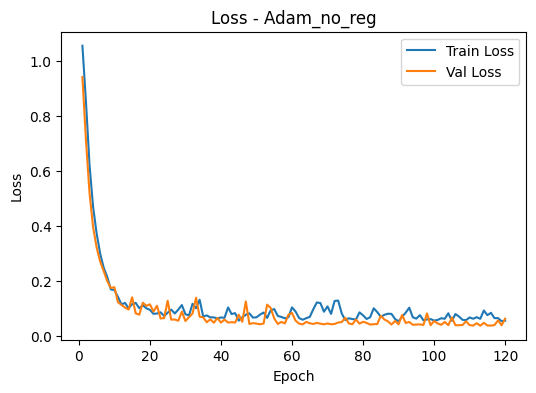

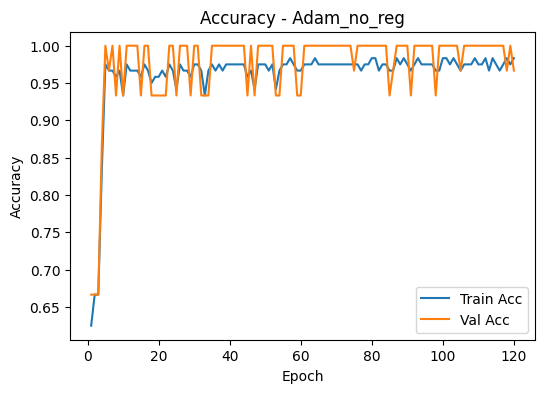

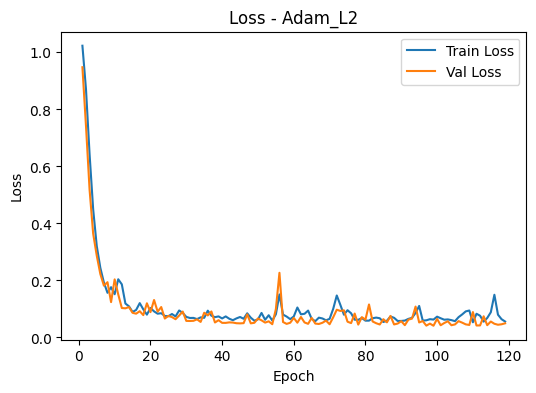

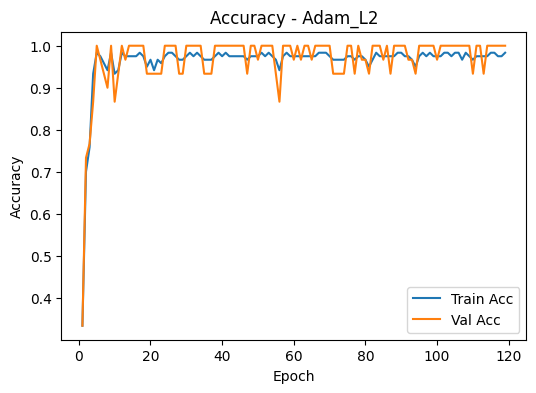

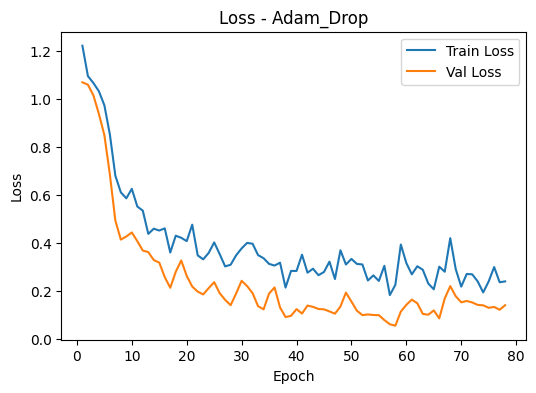

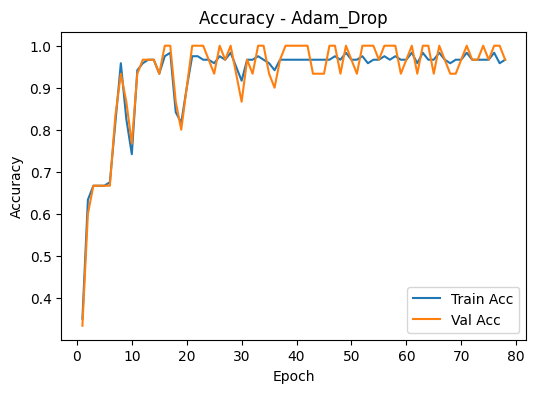

In [29]:
def plot_curves(name, hist):
    epochs = range(1, len(hist["train_loss"])+1)

    # Pérdida
    plt.figure(figsize=(6,4))
    plt.plot(epochs, hist["train_loss"], label="Train Loss")
    plt.plot(epochs, hist["val_loss"], label="Val Loss")
    plt.title(f"Loss - {name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Precisión
    plt.figure(figsize=(6,4))
    plt.plot(epochs, hist["train_acc"], label="Train Acc")
    plt.plot(epochs, hist["val_acc"], label="Val Acc")
    plt.title(f"Accuracy - {name}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

top3 = df_task6.head(3)["name"].tolist()
for n in top3:
    plot_curves(n, task6_histories[n])


#### Task 7- Discusión


Discuta los resultados obtenidos de diferentes modelos. Compare la velocidad de convergencia y el rendimiento final
de modelos utilizando diferentes funciones de pérdida, técnicas de regularización, y algoritmos de optimización.
Explore y discuta por qué ciertas técnicas podrían conducir a un mejor rendimiento. tanto técnicas de regularización,
funciones de pérdida como algoritmos de optimización.

## Ejercicio 2. Repaso de teoría

1. ¿Cuál es la principal innovación de la arquitectura Transformer?

    La gran idea del Transformer es que deja de lado las redes recurrentes y las convoluciones y, en su lugar, usa atención para que cada palabra pueda mirar a las demás de una sola vez; así el modelo entiende relaciones lejanas más fácil, entrena en paralelo (más rápido) y solo necesita agregar una pista del orden de las palabras con “positional encodings”.

2. ¿Cómo funciona el mecanismo de atención del scaled dot-product?

    Cada palabra se compara con todas las otras para ver a cuáles debería “prestarles más atención”; esas comparaciones se convierten en pesos (que suman 1) y se usan para mezclar la información de las palabras importantes. El “escalado” solo evita que los números exploten y el softmax dé resultados raros y en el decodificador se tapa lo que viene después para no hacer trampa.

3. ¿Por qué se utiliza la atención de múltiples cabezales en Transformer?

    Se usan varias “cabezas” de atención porque cada una puede fijarse en cosas distintas al mismo tiempo: una puede mirar concordancias cercanas, otra dependencias lejanas, otra nombres propios, etc. Al juntar todas, el modelo capta más patrones y entiende mejor el texto que si tuviera una sola mirada.

4. ¿Cómo se incorporan los positional encodings en el modelo Transformer?

    Como la atención por sí sola no sabe el orden, al embedding de cada palabra se le suma un vector que depende de su posición los positional encodings. Es como ponerle a cada palabra un GPS de “estoy en la posición 1, 2, 3…”, para que el modelo distinga “el perro muerde al gato” de “el gato muerde al perro”.

5. ¿Cuáles son algunas aplicaciones de la arquitectura Transformer más allá de la machine translation?

    Además de traducir, los Transformers se usan para un montón de cosas: escribir o resumir textos, responder preguntas y chatear, entender y generar código, analizar imágenes, trabajar con audio y voz, combinar texto-imagen, e incluso para datos como secuencias biológicas o series de tiempo. Son versátiles porque la misma idea de atención se adapta a muchos tipos de datos.